In [1]:
# Step 1: Import Libraries and Set Up Environment
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Step 2: Data Preprocessing
print("Preprocessing data...")
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

test_labels = torch.tensor(testset.targets)
print("Data preprocessing complete.")



Preprocessing data...
Data preprocessing complete.


In [4]:
# Step 3: Define and Train ResNet Model
print("Training ResNet...")
resnet = models.resnet18(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Linear(resnet.fc.in_features, 10)  # CIFAR-10 classes
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.fc.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

scaler = torch.cuda.amp.GradScaler()  # Mixed precision training

for epoch in range(3):  # Reduced epochs
    resnet.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # Mixed precision
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')

torch.save(resnet.state_dict(), './models/resnet18.pth')
print("ResNet training complete.")


Training ResNet...


c:\Users\DELL\OneDrive\Desktop\test\llm_pdf_csv_qa_project (1)\Cifar\image\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\OneDrive\Desktop\test\llm_pdf_csv_qa_project (1)\Cifar\image\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\DELL\AppData\Local\Temp\ipykernel_11040\3896216761.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed precision training
c:\Users\D

Epoch 1, Loss: 1.8981626119150226
Epoch 2, Loss: 1.8363743721676604
Epoch 3, Loss: 1.8515753596639999
ResNet training complete.


In [5]:
# Step 4: Define and Train VGG Model
print("Training VGG...")
vgg = models.vgg16(pretrained=True)

# Freeze all layers except the classifier
for param in vgg.features.parameters():
    param.requires_grad = False
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 10)  # CIFAR-10 classes
vgg = vgg.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.classifier.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

for epoch in range(3):  # Reduced epochs
    vgg.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # Mixed precision
            outputs = vgg(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')

torch.save(vgg.state_dict(), './models/vgg16.pth')
print("VGG training complete.")

Training VGG...


c:\Users\DELL\OneDrive\Desktop\test\llm_pdf_csv_qa_project (1)\Cifar\image\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\DELL\AppData\Local\Temp\ipykernel_11040\144277509.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


Epoch 1, Loss: 1.473478032804816
Epoch 2, Loss: 1.2994124811628591
Epoch 3, Loss: 1.2476536413592756
VGG training complete.


In [6]:
# Step 5: Late Fusion
print("Applying Late Fusion...")
def get_predictions(model, dataloader):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = torch.softmax(model(inputs), dim=1)
            all_probs.append(outputs.cpu())
    return torch.cat(all_probs, dim=0)

resnet_probs = get_predictions(resnet, testloader)
vgg_probs = get_predictions(vgg, testloader)

fused_probs = (resnet_probs + vgg_probs) / 2
fused_preds = torch.argmax(fused_probs, dim=1)

correct = (fused_preds == test_labels).sum().item()
late_fusion_accuracy = 100 * correct / len(test_labels)
print(f"Late Fusion Accuracy: {late_fusion_accuracy:.2f}%")


Applying Late Fusion...
Late Fusion Accuracy: 57.69%


In [7]:

# Step 6: Stacking Strategy
print("Applying Stacking...")
X_train = np.concatenate([resnet_probs.numpy(), vgg_probs.numpy()], axis=1)
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_train, test_labels.numpy())

stacking_preds = meta_model.predict(X_train)
stacking_accuracy = accuracy_score(test_labels.numpy(), stacking_preds)
print(f"Stacking Accuracy: {stacking_accuracy * 100:.2f}%")



Applying Stacking...
Stacking Accuracy: 62.48%


In [8]:
# Step 7: Evaluation Metrics
print("Evaluating ResNet...")
resnet_preds = []
with torch.no_grad():
    for inputs, _ in testloader:
        inputs = inputs.to(device)
        outputs = torch.softmax(resnet(inputs), dim=1)
        resnet_preds.append(torch.argmax(outputs, dim=1).cpu())

resnet_preds = torch.cat(resnet_preds)
print("ResNet Classification Report:")
print(classification_report(test_labels, resnet_preds))

print("Late Fusion Classification Report:")
print(classification_report(test_labels, fused_preds))

print("Stacking Classification Report:")
print(classification_report(test_labels, stacking_preds))



Evaluating ResNet...
ResNet Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.47      0.42      1000
           1       0.41      0.50      0.45      1000
           2       0.40      0.15      0.21      1000
           3       0.32      0.39      0.35      1000
           4       0.33      0.59      0.42      1000
           5       0.49      0.18      0.26      1000
           6       0.44      0.48      0.46      1000
           7       0.52      0.30      0.38      1000
           8       0.31      0.47      0.37      1000
           9       0.46      0.27      0.34      1000

    accuracy                           0.38     10000
   macro avg       0.41      0.38      0.37     10000
weighted avg       0.41      0.38      0.37     10000

Late Fusion Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.65      0.63      1000
           1       0.60      0.73      0.65   

Generating Confusion Matrices...


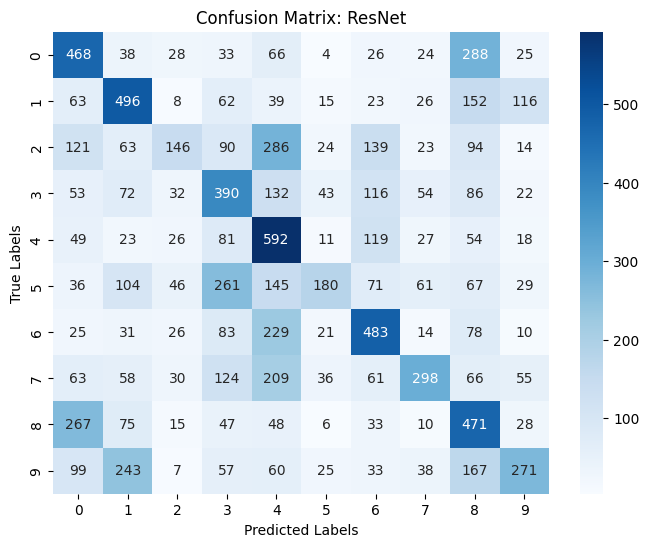

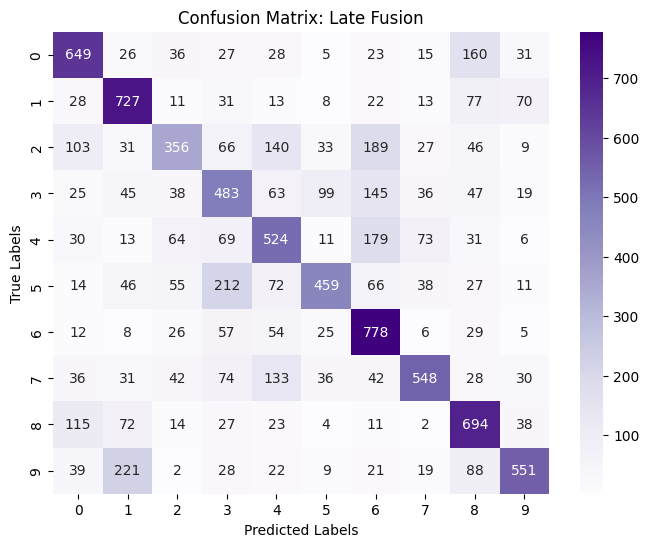

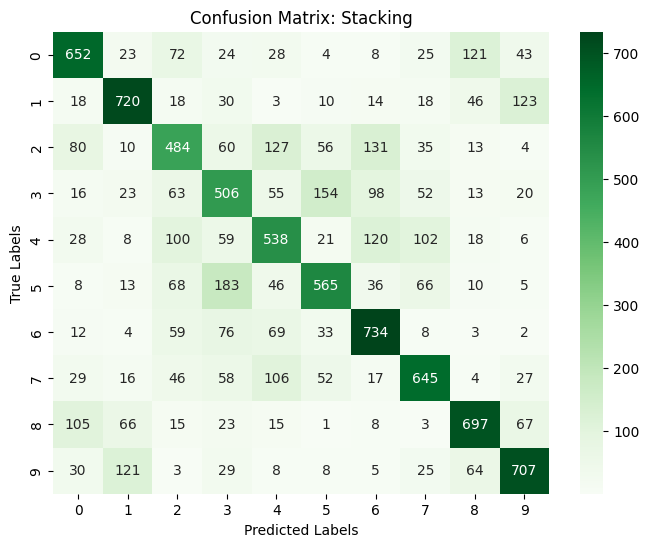

In [9]:
# Step 8: Confusion Matrix
print("Generating Confusion Matrices...")
conf_matrix_resnet = confusion_matrix(test_labels, resnet_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_resnet, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: ResNet")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

conf_matrix_fusion = confusion_matrix(test_labels, fused_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_fusion, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix: Late Fusion")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

conf_matrix_stacking = confusion_matrix(test_labels, stacking_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_stacking, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix: Stacking")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



In [10]:
# Step 10: Summary Table
print("Creating Summary Table...")
results = {
    "Model": ["ResNet", "VGG", "Late Fusion", "Stacking"],
    "Accuracy": [resnet_preds.eq(test_labels).sum().item() / len(test_labels) * 100, 
                 vgg_probs.argmax(dim=1).eq(test_labels).sum().item() / len(test_labels) * 100, 
                 late_fusion_accuracy, 
                 stacking_accuracy * 100],
    "Precision": [
        classification_report(test_labels, resnet_preds, output_dict=True)["weighted avg"]["precision"],
        classification_report(test_labels, vgg_probs.argmax(dim=1), output_dict=True)["weighted avg"]["precision"],
        classification_report(test_labels, fused_preds, output_dict=True)["weighted avg"]["precision"],
        classification_report(test_labels, stacking_preds, output_dict=True)["weighted avg"]["precision"]
    ],
    "Recall": [
        classification_report(test_labels, resnet_preds, output_dict=True)["weighted avg"]["recall"],
        classification_report(test_labels, vgg_probs.argmax(dim=1), output_dict=True)["weighted avg"]["recall"],
        classification_report(test_labels, fused_preds, output_dict=True)["weighted avg"]["recall"],
        classification_report(test_labels, stacking_preds, output_dict=True)["weighted avg"]["recall"]
    ],
    "F1 Score": [
        classification_report(test_labels, resnet_preds, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(test_labels, vgg_probs.argmax(dim=1), output_dict=True)["weighted avg"]["f1-score"],
        classification_report(test_labels, fused_preds, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(test_labels, stacking_preds, output_dict=True)["weighted avg"]["f1-score"]
    ]
}

df_results = pd.DataFrame(results)
print("Summary of Model Performance:")
print(df_results)

Creating Summary Table...
Summary of Model Performance:
         Model  Accuracy  Precision  Recall  F1 Score
0       ResNet     37.95   0.405405  0.3795  0.366948
1          VGG     59.67   0.608572  0.5967  0.591487
2  Late Fusion     57.69   0.588448  0.5769  0.572704
3     Stacking     62.48   0.624846  0.6248  0.624134
